# LEAD CONVERSION ANALYSIS

THE FOLLOWING PROJECT CONSISTS OF THE LEAD CONVERSION DATA OF A COMPANY


In [140]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.metrics import classification_report
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import LabelEncoder , StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split , cross_val_score , cross_validate , cross_val_predict
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier , RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import learning_curve
from sklearn.feature_selection import chi2, SelectKBest, f_classif
from sklearn import metrics

from sklearn.linear_model import LogisticRegression , Perceptron
from sklearn.metrics import confusion_matrix , roc_auc_score , precision_recall_curve , roc_curve
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

# DATA

In [141]:
data = pd.read_excel("lead_data.xlsx")

In [142]:
data.columns

Index(['Unnamed: 0', 'Agent_id', 'status', 'lost_reason', 'budget', 'lease',
       'movein', 'source', 'source_city', 'source_country', 'utm_source',
       'utm_medium', 'des_city', 'des_country', 'room_type', 'lead_id'],
      dtype='object')

In [143]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46608 entries, 0 to 46607
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Unnamed: 0      46608 non-null  int64         
 1   Agent_id        46608 non-null  object        
 2   status          46608 non-null  object        
 3   lost_reason     43244 non-null  object        
 4   budget          42908 non-null  object        
 5   lease           44267 non-null  object        
 6   movein          32970 non-null  datetime64[ns]
 7   source          46608 non-null  object        
 8   source_city     46608 non-null  object        
 9   source_country  46608 non-null  object        
 10  utm_source      46608 non-null  object        
 11  utm_medium      46608 non-null  object        
 12  des_city        46608 non-null  object        
 13  des_country     46608 non-null  object        
 14  room_type       23061 non-null  object        
 15  le

In [144]:
data.shape


(46608, 16)

 # DATA CLEANING

In [145]:
new_data = data[(data.status== "LOST") | (data.status== "WON")] ; new_data.shape

(46317, 16)

In [146]:
new_data.status.unique()

array(['LOST', 'WON'], dtype=object)

For lead conversion analysis I only checked for the statuses of those leads which were WON and the ones which were LOST. 

In [147]:
new_data.isna().sum()

Unnamed: 0            0
Agent_id              0
status                0
lost_reason        3073
budget             3694
lease              2336
movein            13610
source                0
source_city           0
source_country        0
utm_source            0
utm_medium            0
des_city              0
des_country           0
room_type         23491
lead_id               0
dtype: int64

In [148]:
new_data.drop("Unnamed: 0" , axis = 1 , inplace = True)
new_data.drop("Agent_id" , axis = 1 , inplace = True)
new_data.drop("room_type" , axis = 1 , inplace = True)
new_data.drop("lead_id" , axis = 1 , inplace = True)

In [149]:
new_data.lost_reason.fillna(new_data.lost_reason.mode()[0] , inplace = True)
new_data.budget.fillna(new_data.budget.mode()[0] , inplace = True)
new_data.lease.fillna(new_data.lease.mode()[0] , inplace = True)
new_data.movein.fillna(datetime.datetime(2022, 9, 10) , inplace = True)

new_data.isna().sum()

status            0
lost_reason       0
budget            0
lease             0
movein            0
source            0
source_city       0
source_country    0
utm_source        0
utm_medium        0
des_city          0
des_country       0
dtype: int64

Since all the columns are categorical columns all the NA values have been replaced with the mode of the column.
The columns which had way more NA values are futile, so dropped them. 

# DATA PREPROCESSING

In [150]:
new_data.lease = new_data.lease.astype(str)
new_data.movein = new_data.movein.astype(str)

In [151]:
column_list = new_data.columns.values.tolist()

for col in column_list:
    print('\033[1m  {}  \033[0m'.format(col))
    print("Number of total unique value for {} feature is {}:".format(col , len(new_data[col].unique()) ))
    print('\n') 

  status  
Number of total unique value for status feature is 2:


  lost_reason  
Number of total unique value for lost_reason feature is 30:


  budget  
Number of total unique value for budget feature is 1834:


  lease  
Number of total unique value for lease feature is 311:


  movein  
Number of total unique value for movein feature is 469:


  source  
Number of total unique value for source feature is 683:


  source_city  
Number of total unique value for source_city feature is 4316:


  source_country  
Number of total unique value for source_country feature is 185:


  utm_source  
Number of total unique value for utm_source feature is 35:


  utm_medium  
Number of total unique value for utm_medium feature is 64:


  des_city  
Number of total unique value for des_city feature is 220:


  des_country  
Number of total unique value for des_country feature is 15:




In [152]:
new_data.columns

Index(['status', 'lost_reason', 'budget', 'lease', 'movein', 'source',
       'source_city', 'source_country', 'utm_source', 'utm_medium', 'des_city',
       'des_country'],
      dtype='object')

FREQUENCY ENCODING

In [153]:
new_data.groupby("lost_reason").size()/len(new_data)

lost_reason
Booked on campus accommodation   0.01
Booked with competitor           0.01
Booked with manager              0.01
Cross sell                       0.00
Didn't respond in time           0.00
Distance issue                   0.00
Guarantor issue                  0.00
Inadequate details               0.02
Junk lead                        0.01
Junk lead/ Just Enquiring        0.00
Just Enquiring                   0.03
Lead issue                       0.00
Looking for Scholarship          0.00
Looking for admission            0.00
Looking for loan                 0.00
Low availability                 0.26
Low budget                       0.12
No supply                        0.01
Not a student                    0.03
Not going to university          0.01
Not interested                   0.14
Not responding                   0.17
Not serving in that region       0.01
Repeat lead                      0.01
Semester stay                    0.02
Short stay                       0.05


In [154]:
(new_data.groupby("lost_reason").size()/len(new_data)).round(2)

lost_reason
Booked on campus accommodation   0.01
Booked with competitor           0.01
Booked with manager              0.01
Cross sell                       0.00
Didn't respond in time           0.00
Distance issue                   0.00
Guarantor issue                  0.00
Inadequate details               0.02
Junk lead                        0.01
Junk lead/ Just Enquiring        0.00
Just Enquiring                   0.03
Lead issue                       0.00
Looking for Scholarship          0.00
Looking for admission            0.00
Looking for loan                 0.00
Low availability                 0.26
Low budget                       0.12
No supply                        0.01
Not a student                    0.03
Not going to university          0.01
Not interested                   0.14
Not responding                   0.17
Not serving in that region       0.01
Repeat lead                      0.01
Semester stay                    0.02
Short stay                       0.05


In [155]:
((new_data.groupby("lost_reason").size()/len(new_data)).round(2)).unique() 

array([0.01, 0.  , 0.02, 0.03, 0.26, 0.12, 0.14, 0.17, 0.05, 0.06])

Using frequency encoding we reduced the unique values from 30 to 10

In [156]:
l = ['lost_reason', 'budget', 'lease', 'movein', "source" , "source_city" ,
     'source_country', 'utm_source', 'utm_medium', 'des_city', 'des_country']
for i in l:
    fe = new_data.groupby(i).size()
    fe_ = fe/len(new_data)
    new_data[i + "_freq"] = new_data[i].map(fe_).round(2)

In [157]:
new_data.columns

Index(['status', 'lost_reason', 'budget', 'lease', 'movein', 'source',
       'source_city', 'source_country', 'utm_source', 'utm_medium', 'des_city',
       'des_country', 'lost_reason_freq', 'budget_freq', 'lease_freq',
       'movein_freq', 'source_freq', 'source_city_freq', 'source_country_freq',
       'utm_source_freq', 'utm_medium_freq', 'des_city_freq',
       'des_country_freq'],
      dtype='object')

In [158]:
frequency_col = ['lost_reason_freq', 'budget_freq', 'lease_freq',
       'movein_freq', 'source_freq', 'source_city_freq', 'source_country_freq',
       'utm_source_freq', 'utm_medium_freq', 'des_city_freq',
       'des_country_freq']

for col in frequency_col:
    print('\033[1m  {}  \033[0m'.format(col))
    print(new_data[col].unique())
    print("Number of total unique value for {} feature is {}:".format(col , len(new_data[col].unique()) ))
    print('\n') 


  lost_reason_freq  
[0.17 0.12 0.01 0.06 0.05 0.26 0.14 0.03 0.   0.02]
Number of total unique value for lost_reason_freq feature is 10:


  budget_freq  
[0.29 0.19 0.12 0.01 0.05 0.03 0.   0.02]
Number of total unique value for budget_freq feature is 8:


  lease_freq  
[0.29 0.16 0.01 0.09 0.06 0.14 0.03 0.02 0.   0.05 0.04]
Number of total unique value for lease_freq feature is 11:


  movein_freq  
[0.35 0.05 0.01 0.03 0.   0.02]
Number of total unique value for movein_freq feature is 6:


  source_freq  
[0.13 0.41 0.08 0.05 0.01 0.   0.02]
Number of total unique value for source_freq feature is 7:


  source_city_freq  
[0.19 0.01 0.   0.03 0.02 0.07]
Number of total unique value for source_city_freq feature is 6:


  source_country_freq  
[0.19 0.4  0.15 0.   0.02 0.04 0.01]
Number of total unique value for source_country_freq feature is 7:


  utm_source_freq  
[0.04 0.67 0.01 0.02 0.   0.03 0.1 ]
Number of total unique value for utm_source_freq feature is 7:


  utm_medium_f

In [159]:
new_data.drop(['lost_reason', 'budget', 'lease', 'movein', 'source',
       'source_city', 'source_country', 'utm_source', 'utm_medium', 'des_city',
       'des_country'] , axis = 1 , inplace = True)

In [160]:
new_data.head()

,status,lost_reason_freq,budget_freq,lease_freq,movein_freq,source_freq,source_city_freq,source_country_freq,utm_source_freq,utm_medium_freq,des_city_freq,des_country_freq
0,LOST,0.17,0.29,0.29,0.35,0.13,0.19,0.19,0.04,0.04,0.16,0.92
1,LOST,0.12,0.29,0.29,0.35,0.13,0.19,0.19,0.04,0.04,0.03,0.92
2,LOST,0.17,0.19,0.29,0.05,0.41,0.01,0.40,0.67,0.68,0.07,0.92
3,LOST,0.12,0.12,0.16,0.35,0.08,0.00,0.40,0.67,0.68,0.01,0.92
4,LOST,0.01,0.29,0.29,0.35,0.13,0.19,0.19,0.04,0.04,0.05,0.05


# EDA

In [161]:
y = new_data["status"]
x = new_data.iloc[: , 1:]

In [162]:
y[y == "LOST"] = 0 
y[y == "WON"] = 1 

In [163]:
y.value_counts()

0    43244
1     3073
Name: status, dtype: int64

In [164]:
x.shape , y.shape

((46317, 11), (46317,))

In [165]:
 def get_feature_correlation(df, top_n=None, corr_method='spearman',
                            remove_duplicates=True, remove_self_correlations=True):
    
    corr_matrix_abs = df.corr(method=corr_method).abs()
    corr_matrix_abs_us = corr_matrix_abs.unstack()
    sorted_correlated_features = corr_matrix_abs_us \
        .sort_values( ascending=False) \
        .reset_index()

    if remove_self_correlations:
        sorted_correlated_features = sorted_correlated_features[
            (sorted_correlated_features.level_0 != sorted_correlated_features.level_1)
        ]
        
    if remove_duplicates:
        sorted_correlated_features = sorted_correlated_features.drop_duplicates([0])


    sorted_correlated_features.columns = ['Feature 1', 'Feature 2', 'Correlation (abs)'] 

    if top_n:
        return sorted_correlated_features[:top_n]

    return sorted_correlated_features

In [166]:
get_feature_correlation(new_data, top_n=None, corr_method='spearman',
                            remove_duplicates=True, remove_self_correlations=True)
    

,Feature 1,Feature 2,Correlation (abs)
11,utm_medium_freq,utm_source_freq,0.77
13,utm_medium_freq,source_freq,0.58
15,source_freq,utm_source_freq,0.53
17,source_freq,budget_freq,0.53
19,utm_medium_freq,source_city_freq,0.52
21,source_city_freq,utm_source_freq,0.47
23,budget_freq,lease_freq,0.43
25,movein_freq,source_freq,0.39
27,source_city_freq,source_freq,0.36
29,lease_freq,source_freq,0.27


<AxesSubplot:>

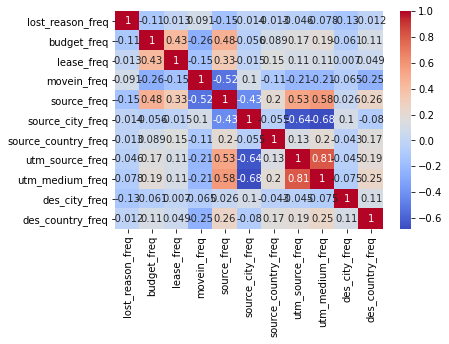

In [167]:
corr_matrix = new_data.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')


budget_freq and source_freq are highly correlated after which source_freq and movein_freq are correlated

# HANDLING CLASS IMBALANCE

OVERSAMPLING

In [221]:
y.value_counts()

0    43244
1     3073
Name: status, dtype: int64

In [222]:
y = y.astype(int)

In [223]:
oversample = SMOTE()
a, b= oversample.fit_resample(x, y)

In [224]:
a.shape , b.shape

((86488, 11), (86488,))

In [225]:
counter = Counter(b)
print(counter)

Counter({0: 43244, 1: 43244})


In [226]:
counter = Counter(y)
print(counter)

Counter({0: 43244, 1: 3073})


TRAINGING AND TESTING MODELS FOR OVERSAMPLED DATA

In [227]:
x_train  , x_test , y_train , y_test = train_test_split(a , b , test_size = 0.2 , random_state = 0)


In [228]:
# Extra Trees Classifier 
extra_clf = ExtraTreesClassifier()
extra_scores = cross_val_score(extra_clf, x_train, y_train, cv=5)
extra_mean = extra_scores.mean()

# Gradient Boosting Classifier
grad_clf = GradientBoostingClassifier()
grad_scores = cross_val_score(grad_clf, x_train, y_train, cv=5)
grad_mean = grad_scores.mean()

# Random Forest Classifier
rand_clf = RandomForestClassifier()
rand_scores = cross_val_score(rand_clf, x_train, y_train, cv=5)
rand_mean = rand_scores.mean()

# LGBM Classifier
lgbm_clf = LGBMClassifier()
lgbm_scores = cross_val_score(lgbm_clf, x_train, y_train, cv=5)
lgbm_mean = lgbm_scores.mean()

# KNeighbors Classifier
knn_clf = KNeighborsClassifier()
knn_scores = cross_val_score(knn_clf, x_train, y_train, cv=5)
knn_mean = knn_scores.mean()

#Perceptron
per = Perceptron()
per_scores = cross_val_score(per, x_train, y_train, cv=5)
per_mean = per_scores.mean()


d = {'Classifiers': ["ExtraTreesclf" , "GradientBosstingclf" , "RandomForest" ,"LGBMclf" , "KNN" , "Perceptron" ], 
    'Crossval Mean Scores': [extra_mean , grad_mean , rand_mean , lgbm_mean , knn_mean , per_mean]}

result_df = pd.DataFrame(data=d)


In [229]:
result_df

,Classifiers,Crossval Mean Scores
0,ExtraTreesclf,0.97
1,GradientBosstingclf,0.95
2,RandomForest,0.97
3,LGBMclf,0.97
4,KNN,0.95
5,Perceptron,0.90


In [230]:
mean_acc_oversampled = np.zeros(11)
for i in range(1,12):
    rf = RandomForestClassifier(random_state = 0)
    x_new_ = SelectKBest(chi2, k = i).fit_transform(m , n )
    x_train  , x_test , y_train , y_test = train_test_split(x_new_ , n , test_size = 0.2 , random_state = 0)
    rf.fit(x_train , y_train)
    yhat= rf.predict(x_test)
    mean_acc_oversampled[i-1] = metrics.accuracy_score(y_test, yhat)
mean_acc_oversampled    

array([0.60731707, 0.66341463, 0.69430894, 0.76747967, 0.80894309,
       0.81056911, 0.80650407, 0.81544715, 0.81056911, 0.82113821,
       0.82113821])

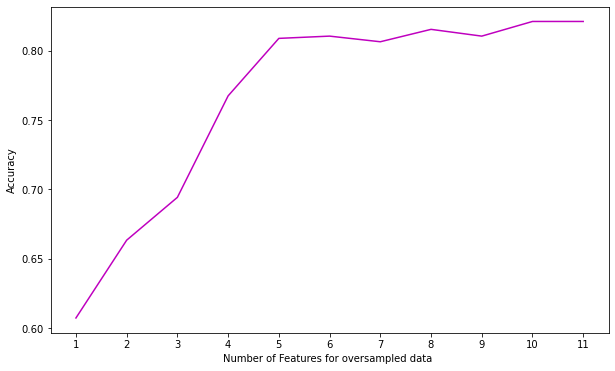

In [231]:
loc = np.arange(1,12,step=1.0)
plt.figure(figsize = (10, 6) )
plt.plot(range(1,12), mean_acc_oversampled , color = "m")
plt.xticks(loc)
plt.xlabel('Number of Features for oversampled data ')
plt.ylabel('Accuracy')
plt.show()

As the number of features increase the accuracy increases, so I don't think there's any need for any
dimensionality reduction technique

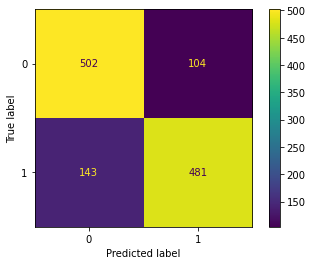

In [232]:
rf.fit(x_train , y_train)
    
predictions = rf.predict(x_test)
cm = confusion_matrix(y_test, predictions, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=rf.classes_)
disp.plot()

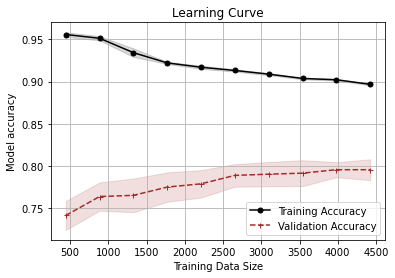

In [233]:
train_sizes, train_scores, test_scores = learning_curve(estimator=rf , X=x_train, y=y_train,
                                                       cv=10, train_sizes=np.linspace(0.1, 1.0, 10),
                                                     n_jobs=1)


train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Ploting the learning curve

plt.plot(train_sizes, train_mean, color='black', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='black')
plt.plot(train_sizes, test_mean, color='brown', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='brown')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

Intially the training model had very high accuracy whereas validation model had comparatively lower accuracy which is a case of overfitting, but as more and more samples are added to the model the accuracy imporved.

UNDERSAMPLING

In [187]:
print("Before Undersampling, counts of label '1': {}".format(sum(y == 1)))
print("Before Undersampling, counts of label '0': {} \n".format(sum(y == 0)))
  
nr = NearMiss()
  
m, n = nr.fit_sample(x, y.ravel())
  
print('After Undersampling, the shape of train_X: {}'.format(m.shape))
print('After Undersampling, the shape of train_y: {} \n'.format(n.shape))
  
print("After Undersampling, counts of label '1': {}".format(sum(n == 1)))
print("After Undersampling, counts of label '0': {}".format(sum(n == 0)))

Before Undersampling, counts of label '1': 3073
Before Undersampling, counts of label '0': 43244 

After Undersampling, the shape of train_X: (6146, 11)
After Undersampling, the shape of train_y: (6146,) 

After Undersampling, counts of label '1': 3073
After Undersampling, counts of label '0': 3073


In [188]:
x_train  , x_test , y_train , y_test = train_test_split(m,n, test_size = 0.2 , random_state = 0)

In [189]:
# Extra Trees Classifier 
extra_clf = ExtraTreesClassifier()
extra_scores = cross_val_score(extra_clf, x_train, y_train, cv=5)
extra_mean = extra_scores.mean()

# Gradient Boosting Classifier
grad_clf = GradientBoostingClassifier()
grad_scores = cross_val_score(grad_clf, x_train, y_train, cv=5)
grad_mean = grad_scores.mean()

# Random Forest Classifier
rand_clf = RandomForestClassifier()
rand_scores = cross_val_score(rand_clf, x_train, y_train, cv=5)
rand_mean = rand_scores.mean()

# LGBM Classifier
lgbm_clf = LGBMClassifier()
lgbm_scores = cross_val_score(lgbm_clf, x_train, y_train, cv=5)
lgbm_mean = lgbm_scores.mean()

# KNeighbors Classifier
knn_clf = KNeighborsClassifier()
knn_scores = cross_val_score(knn_clf, x_train, y_train, cv=5)
knn_mean = knn_scores.mean()

#Perceptron
per = Perceptron()
per_scores = cross_val_score(per, x_train, y_train, cv=5)
per_mean = per_scores.mean()


d = {'Classifiers': ["ExtraTreesclf" , "GradientBosstingclf" , "RandomForest" ,"LGBMclf" , "KNN" , "Perceptron" ], 
    'Crossval Mean Scores': [extra_mean , grad_mean , rand_mean , lgbm_mean , knn_mean , per_mean]}

result_df = pd.DataFrame(data=d)

In [190]:
result_df.sort_values(by = ["Crossval Mean Scores"] , ascending = False)

,Classifiers,Crossval Mean Scores
3,LGBMclf,0.81
2,RandomForest,0.80
1,GradientBosstingclf,0.79
0,ExtraTreesclf,0.79
4,KNN,0.77
5,Perceptron,0.63


In [204]:
mean_acc_undersampled = np.zeros(11)
for i in range(1,12):
    lgbm = LGBMClassifier(random_state = 0)
    x_new_ = SelectKBest(chi2, k = i).fit_transform(m , n )
    x_train  , x_test , y_train , y_test = train_test_split(x_new_ , n , test_size = 0.2 , random_state = 0)
    lgbm.fit(x_train , y_train)
    yhat= lgbm.predict(x_test)
    mean_acc_undersampled[i-1] = metrics.accuracy_score(y_test, yhat)
mean_acc_undersampled    



array([0.60731707, 0.66341463, 0.69430894, 0.76747967, 0.80894309,
       0.81056911, 0.80650407, 0.81544715, 0.81056911, 0.82113821,
       0.82113821])

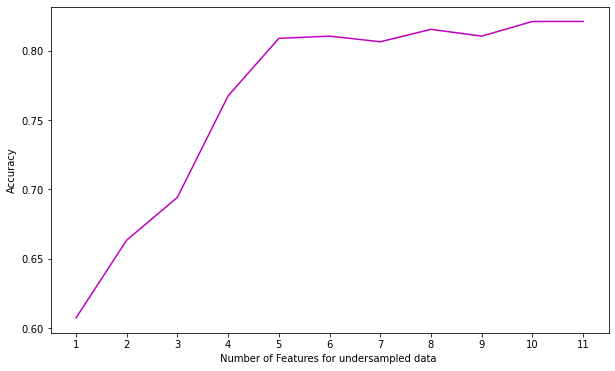

In [202]:
loc = np.arange(1,12,step=1.0)
plt.figure(figsize = (10, 6))
plt.plot(range(1,12), mean_acc_undersampled , color = "m")
plt.xticks(loc)
plt.xlabel('Number of Features for undersampled data ')
plt.ylabel('Accuracy')
plt.show()

Considering all the features helps perform the model optimally in undersampling 

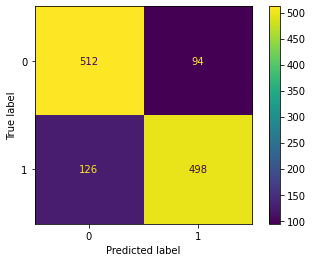

In [205]:
lgbm.fit(x_train , y_train)
    
predictions = lgbm.predict(x_test)
cm = confusion_matrix(y_test, predictions, labels=lgbm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=lgbm.classes_)
disp.plot()

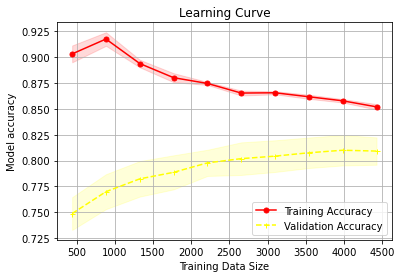

In [206]:
train_sizes, train_scores, test_scores = learning_curve(estimator=lgbm, X=x_train, y=y_train,
                                                       cv=10, train_sizes=np.linspace(0.1, 1.0, 10),
                                                     n_jobs=1)


train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Ploting the learning curve

plt.plot(train_sizes, train_mean, color='red', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='red')
plt.plot(train_sizes, test_mean, color='yellow', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='yellow')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

We see similar patterns for undersampling as well

# METRICS 

USING UNDERSAMPLED DATA TO GET FINAL METRICS

In [207]:
from sklearn.metrics import f1_score , precision_score , recall_score
lgbm.fit(x_train , y_train)
pred = lgbm.predict(x_test)
print('Precision Score: ', precision_score(y_test, pred))
print('Recall Score: ', recall_score(y_test, pred))

Precision Score:  0.8412162162162162
Recall Score:  0.7980769230769231


In [208]:
from sklearn.metrics import f1_score , roc_auc_score
f1_score(y_test, pred)

0.819078947368421

In [210]:
y_pred = lgbm.predict_proba(x_test)[:, 1]

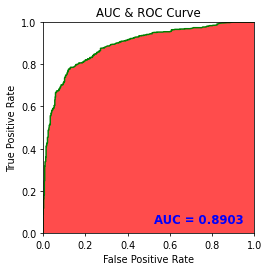

In [211]:
auc = roc_auc_score(y_test, y_pred)

false_positive_rate, true_positive_rate, thresolds = roc_curve(y_test, y_pred)

plt.figure(figsize=(6, 4), dpi=70)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='red', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()  

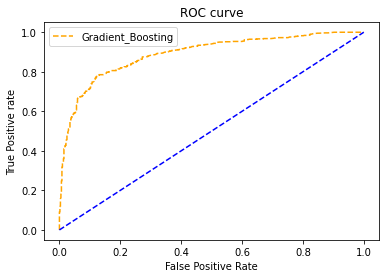

In [212]:
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

plt.plot(false_positive_rate, true_positive_rate, linestyle='--',color='orange', label='Gradient_Boosting')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();